In [3]:
import torch

num_gpus = torch.cuda.device_count()
num_cpus = torch.get_num_threads()

print(f"Number of available CPU cores: {num_cpus}")
print(f"Number of available GPUs: {num_gpus}")

Number of available CPU cores: 1
Number of available GPUs: 1


In [4]:
!pip install torch torchvision albumentations

In [5]:
!git clone https://github.com/aliabbasi2000/PIDNet.git
%cd /content/PIDNet/

Cloning into 'PIDNet'...
remote: Enumerating objects: 595, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 595 (delta 17), reused 17 (delta 8), pack-reused 558 (from 1)
Receiving objects: 100% (595/595), 246.53 MiB | 19.42 MiB/s, done.
Resolving deltas: 100% (245/245), done.
Updating files: 100% (130/130), done.
/content/PIDNet


In [6]:
!wget https://zenodo.org/record/5706578/files/Train.zip
!wget https://zenodo.org/record/5706578/files/Val.zip
!unzip Train.zip -d ./LoveDA
!unzip Val.zip -d ./LoveDA

Streaming output truncated to the last 5000 lines.
 extracting: ./LoveDA/Train/Urban/images_png/2025.png  
 extracting: ./LoveDA/Train/Urban/images_png/2026.png  
 extracting: ./LoveDA/Train/Urban/images_png/2027.png  
 extracting: ./LoveDA/Train/Urban/images_png/2028.png  
 extracting: ./LoveDA/Train/Urban/images_png/2029.png  
 extracting: ./LoveDA/Train/Urban/images_png/2030.png  
  inflating: ./LoveDA/Train/Urban/images_png/2031.png  
 extracting: ./LoveDA/Train/Urban/images_png/2032.png  
 extracting: ./LoveDA/Train/Urban/images_png/2033.png  
  inflating: ./LoveDA/Train/Urban/images_png/2034.png  
  inflating: ./LoveDA/Train/Urban/images_png/2035.png  
 extracting: ./LoveDA/Train/Urban/images_png/2036.png  
 extracting: ./LoveDA/Train/Urban/images_png/2037.png  
 extracting: ./LoveDA/Train/Urban/images_png/2038.png  
 extracting: ./LoveDA/Train/Urban/images_png/2039.png  
 extracting: ./LoveDA/Train/Urban/images_png/2040.png  
 extracting: ./LoveDA/Train/Urban/images_png/2041.png

In [7]:
!wget --content-disposition "https://drive.usercontent.google.com/u/0/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download"
!mv PIDNet_S_ImageNet.pth.tar /content/PIDNet/pretrained_models/imagenet

--2025-01-28 11:01:28--  https://drive.usercontent.google.com/u/0/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.170.132, 2404:6800:4008:c19::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.170.132|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.usercontent.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download [following]
--2025-01-28 11:01:29--  https://drive.usercontent.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download
Reusing existing connection to drive.usercontent.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download [following]
--2025-01-28 11:01:30--  https://drive.usercontent.google.com/download?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download
Reusing e

In [8]:
import os
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from albumentations import Compose, Normalize, Resize
from albumentations.pytorch import ToTensorV2
import cv2

class LoveDADataset(Dataset):
    def __init__(self, root, split='train', region='urban', transform=None):
        self.root = root
        self.split = split
        self.region = region
        self.image_dir = os.path.join(root, split, region, 'images_png')
        self.mask_dir = os.path.join(root, split, region, 'masks_png')
        self.images = sorted(os.listdir(self.image_dir))
        self.masks = sorted(os.listdir(self.mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      image_path = os.path.join(self.image_dir, self.images[idx])
      mask_path = os.path.join(self.mask_dir, self.masks[idx])

      # Load the image and mask
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

      # Convert mask to tensor and shift labels
      mask = np.array(mask, dtype=np.int64) - 1  # Shift labels to range [0, 6]
      mask = np.clip(mask, 0, num_classes - 1)  # Ensure no negative values

      # Apply transformations if specified
      if self.transform:
          augmented = self.transform(image=image, mask=mask)
          image = augmented["image"]
          mask = augmented["mask"]

      # Convert to PyTorch tensors
      image = image.clone().detach().float()  # HWC to CHW
      mask = mask.clone().detach().long()

      return image, mask


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [9]:
from torch.utils.data import DataLoader
from albumentations import Compose, HorizontalFlip, RandomRotate90, Resize, Normalize
from torchvision.transforms import ToTensor
from torchvision import transforms
from albumentations.pytorch import ToTensorV2

train_transform = Compose([
    Resize(512, 512),  # Resize both image and mask
    #####    AUGMENTATION HERE      #######
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()  # Convert to PyTorch tensors
])

# Define transforms for the evaluation phase

eval_transform = Compose([
    Resize(512, 512),  # Resize to match the input size of the model
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()  # Convert to PyTorch tensors
])

# Define dataset paths
data_root = '/content/PIDNet/LoveDA'


# Load datasets
train_dataset = LoveDADataset(root=data_root, split='Train', region='Urban', transform=train_transform)
val_dataset = LoveDADataset(root=data_root, split='Val', region='Rural', transform=eval_transform)


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)



In [41]:
import torch
from models.pidnet import get_seg_model
import yaml

import gc

# Clear GPU cache
torch.cuda.empty_cache()

# Delete existing model and optimizer
del model
del optimizer
gc.collect()

## get_pred ------------------------------------
#model = get_pred_model('pidnet_s', num_classes=7)

## get_seg ------------------------------------
# Convert the dictionary to a DotDict
class DotDict(dict):
    """A dictionary that supports attribute-style access."""
    def __getattr__(self, name):
        value = self.get(name)
        if isinstance(value, dict):
            return DotDict(value)
        return value

    def __setattr__(self, name, value):
        self[name] = value

# Load the YAML configuration
with open('/content/PIDNet/configs/loveda/pidnet_small_loveda.yaml', 'r') as f:
    cfg_dict = yaml.safe_load(f)

# Convert to DotDict for attribute-style access
cfg = DotDict(cfg_dict)

imgnet = 'imagenet' in cfg.MODEL.PRETRAINED

model = get_seg_model(cfg, imgnet_pretrained=imgnet)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)




In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BoundaryLoss(nn.Module):
    def __init__(self, theta=3, smooth=1e-5):
        super(BoundaryLoss, self).__init__()
        self.theta = theta
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Add small epsilon to prevent division by zero
        inputs = F.softmax(inputs, dim=1) + self.smooth
        num_classes = inputs.size(1)

        # Define Sobel filters
        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]],
                              device=inputs.device).float().view(1, 1, 3, 3)
        sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]],
                              device=inputs.device).float().view(1, 1, 3, 3)

        boundary_loss = 0
        for i in range(num_classes):
            pred_i = inputs[:, i:i+1, ...]
            target_i = (targets == i).float().unsqueeze(1) + self.smooth

            # Calculate gradients with numerical stability
            pred_grad_x = F.conv2d(pred_i, sobel_x, padding=1)
            pred_grad_y = F.conv2d(pred_i, sobel_y, padding=1)
            target_grad_x = F.conv2d(target_i, sobel_x, padding=1)
            target_grad_y = F.conv2d(target_i, sobel_y, padding=1)

            # Add small epsilon to prevent sqrt of negative numbers
            pred_boundary = torch.sqrt(pred_grad_x**2 + pred_grad_y**2 + self.smooth)
            target_boundary = torch.sqrt(target_grad_x**2 + target_grad_y**2 + self.smooth)

            # Use L1 loss instead of MSE for better stability
            boundary_loss += F.l1_loss(pred_boundary, target_boundary)

        return boundary_loss / num_classes

criterion = BoundaryLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)


In [27]:
!pip install torchinfo

In [43]:
import torch.nn.functional as F
from torchinfo import summary
import time
import numpy as np

def calculate_iou(predictions, ground_truth, num_classes):
    classwise_iou = []
    for cls in range(num_classes):
        tp = ((predictions == cls) & (ground_truth == cls)).sum().item()
        fp = ((predictions == cls) & (ground_truth != cls)).sum().item()
        fn = ((predictions != cls) & (ground_truth == cls)).sum().item()

        if tp + fp + fn == 0:
            iou = float('nan')
        else:
            iou = tp / (tp + fp + fn)
        classwise_iou.append(iou)

    return classwise_iou

# Training
model.train()
num_epochs = 20
num_classes = 7
class_labels = ["background", "building", "road", "water", "barren", "forest", "agriculture"]
epoch_train_miou = []  # To store training mIoU per epoch
epoch_val_miou = []    # To store validation mIoU per epoch
epoch_train_loss = []  # To store training loss per epoch
epoch_val_loss = []    # To store validation loss per epoch

final_avg_latency = 0.0
final_flops = 0.0
final_params = 0

for epoch in range(num_epochs):
    # Training phase
    train_loss = 0.0
    total_latency = 0.0
    train_classwise_iou = np.zeros(num_classes)
    num_batches = 0

    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        start_time = time.time()
        outputs = model(images)
        latency = time.time() - start_time
        total_latency += latency

        outputs = outputs[0]
        masks = F.interpolate(masks.unsqueeze(1).float(), size=(outputs.shape[2], outputs.shape[3]), mode='nearest').squeeze(1).long()
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        batch_iou = calculate_iou(preds, masks, num_classes)
        train_classwise_iou += np.nan_to_num(batch_iou)
        num_batches += 1

    train_loss /= len(train_loader)
    avg_latency = total_latency / len(train_loader)
    mean_classwise_iou = train_classwise_iou / num_batches
    train_mean_iou = np.nanmean(mean_classwise_iou)
    epoch_train_miou.append(train_mean_iou)
    epoch_train_loss.append(train_loss)

    if epoch == num_epochs - 1:  # Save latency, FLOPs, and Params only for the final epoch
        final_avg_latency = avg_latency
        flops_summary = summary(model, input_size=(1, *images.shape[1:]), verbose=0)
        final_flops = flops_summary.total_mult_adds
        final_params = flops_summary.total_params

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training mIoU: {train_mean_iou:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_classwise_iou = np.zeros(num_classes)
    num_batches = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = outputs[0]
            masks = F.interpolate(masks.unsqueeze(1).float(), size=(outputs.shape[2], outputs.shape[3]), mode='nearest').squeeze(1).long()
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            batch_iou = calculate_iou(preds, masks, num_classes)
            val_classwise_iou += np.nan_to_num(batch_iou)
            num_batches += 1

    val_loss /= len(val_loader)
    mean_classwise_iou = val_classwise_iou / num_batches
    val_mean_iou = np.nanmean(mean_classwise_iou)
    epoch_val_miou.append(val_mean_iou)
    epoch_val_loss.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation mIoU: {val_mean_iou:.4f}")

# Print final results
print(f"\nFinal Average Latency: {final_avg_latency:.4f} seconds")
print(f"Final FLOPs: {final_flops:.2f}")
print(f"Final Params: {final_params}")

print("Class-wise IoU:")
for cls, label in enumerate(class_labels):
    print(f"  {label}: {mean_classwise_iou[cls]:.4f}")


Epoch 1/20, Training Loss: 0.5513, Training mIoU: 0.0638
Epoch 1/20, Validation Loss: 0.3046, Validation mIoU: 0.0555
Epoch 2/20, Training Loss: 0.4471, Training mIoU: 0.0576
Epoch 2/20, Validation Loss: 0.3011, Validation mIoU: 0.0246
Epoch 3/20, Training Loss: 0.4366, Training mIoU: 0.0594
Epoch 3/20, Validation Loss: 0.3003, Validation mIoU: 0.0326
Epoch 4/20, Training Loss: 0.4292, Training mIoU: 0.0654
Epoch 4/20, Validation Loss: 0.2991, Validation mIoU: 0.0606
Epoch 5/20, Training Loss: 0.4241, Training mIoU: 0.0805
Epoch 5/20, Validation Loss: 0.3006, Validation mIoU: 0.0893
Epoch 6/20, Training Loss: 0.4185, Training mIoU: 0.0960
Epoch 6/20, Validation Loss: 0.2962, Validation mIoU: 0.0824
Epoch 7/20, Training Loss: 0.4077, Training mIoU: 0.1220
Epoch 7/20, Validation Loss: 0.3216, Validation mIoU: 0.1266
Epoch 8/20, Training Loss: 0.3907, Training mIoU: 0.1376
Epoch 8/20, Validation Loss: 0.3239, Validation mIoU: 0.0873
Epoch 9/20, Training Loss: 0.3753, Training mIoU: 0.1306

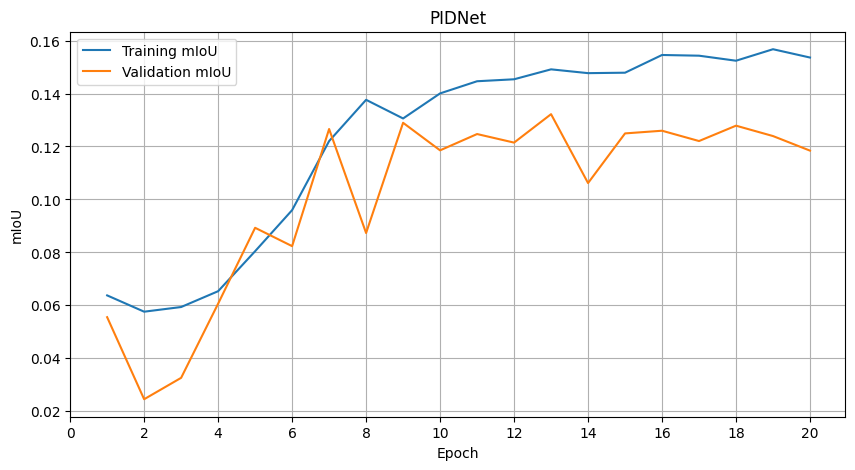

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_train_miou, label='Training mIoU')
plt.plot(range(1, num_epochs + 1), epoch_val_miou, label='Validation mIoU')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('PIDNet')
plt.legend()
plt.grid(True)
plt.xticks(range(0, num_epochs + 2, 2))
plt.show()



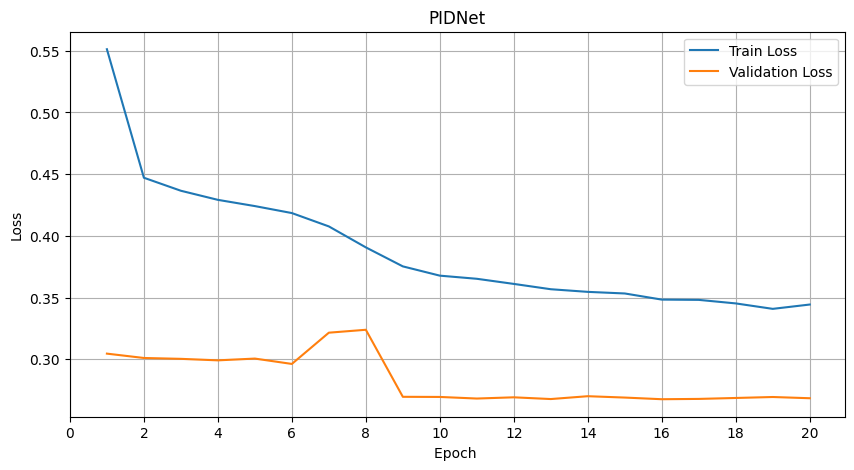

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), epoch_val_loss, label="Validation Loss")
plt.xlabel("Epoch ")
plt.ylabel("Loss")
plt.title("PIDNet")
plt.legend()
plt.grid(True)
plt.xticks(range(0, num_epochs + 2, 2))
plt.show()

In [34]:
# Download the Test Image
!mkdir -p LoveDA/Test/Rural

!wget https://github.com/aliabbasi2000/Real-time-Domain-Adaptation-in-Semantic-Segmentation/blob/280a73361b252434aa65f9602b4b51714d092015/data/LoveDA/Test/Rural/4196.png -O LoveDA/Test/Rural/4196.png


--2025-01-28 13:21:19--  https://github.com/aliabbasi2000/Real-time-Domain-Adaptation-in-Semantic-Segmentation/blob/280a73361b252434aa65f9602b4b51714d092015/data/LoveDA/Test/Rural/4196.png
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-01-28 13:21:19 ERROR 404: Not Found.



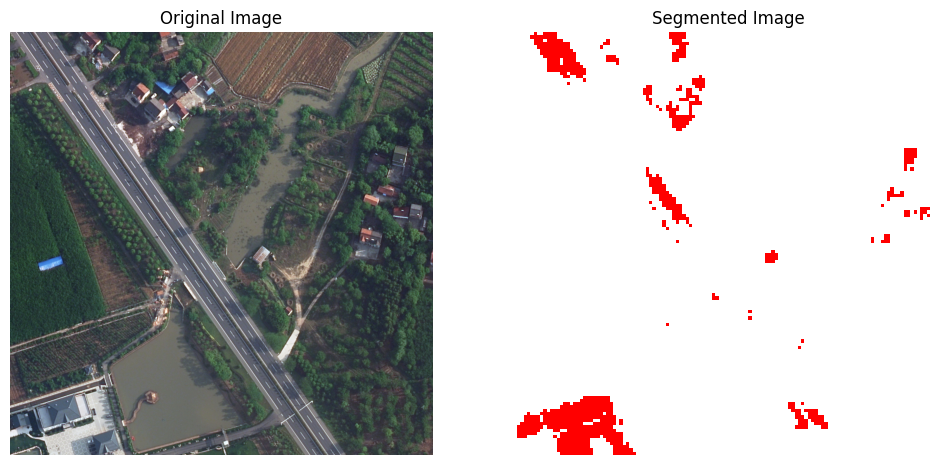

In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Define label colors (R, G, B) for each class
class_labels = ["background", "building", "road", "water", "barren", "forest", "agriculture"]
label_colors = {
    "background": (255, 255, 255),        # White
    "building": (255, 0, 0),             # Red
    "road": (255, 255, 0),               # Yellow
    "water": (0, 0, 255),                # Blue
    "barren": (159, 129, 183),           # Purple
    "forest": (0, 255, 0),               # Green
    "agriculture": (255, 195, 128)       # Peach
}

# Load a single image for segmentation
image_path = "/content/PIDNet/LoveDA/Test/Rural"
image_files = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f)) and not f.startswith('.')]
image_name = image_files[0]
image = Image.open(os.path.join(image_path, image_name)).convert('RGB')



# Preprocess the image (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_image = transform(image).unsqueeze(0).to(device)

# Perform inference with the model
model.eval()
with torch.no_grad():
    output = model(input_image)  # Shape: (1, num_classes, H, W)
    output = output[0]  # Remove auxiliary outputs if present
    preds = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Shape: (H, W)

# Create a segmentation map
segmentation_map = np.zeros((preds.shape[0], preds.shape[1], 3), dtype=np.uint8)

for label_index, label_name in enumerate(class_labels):
    color = label_colors[label_name]
    segmentation_map[preds == label_index] = color

# Visualize the original image and segmentation map
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmentation_map)
plt.title("Segmented Image")
plt.axis("off")

plt.show()